# Using Traditional Clustering Methods on LSTM based model for Speaker Diarization
Here we will train a LSTM model on MFCC features collected during data preprocessing. The embeddings that follow shall then be passed onto various traditional clustering algorithms for segregation of speakers. This shall set the benchmarks for our GANMM model implemented in the 'LSTM_GANMM_model.ipynb' file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/EE698 speaker diarization project

## Importing the essential Libraries

In [ ]:
!pip3 install spectralcluster
!pip install tensorflow_addons 

     |████████████████████████████████| 706kB 7.6MB/s 


In [ ]:
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [ ]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [ ]:
!pip install pyannote.metrics

     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 


In [ ]:
!pip install pyannote.core

     |████████████████████████████████| 61kB 5.0MB/s 
     |████████████████████████████████| 133kB 10.9MB/s 


In [ ]:
from pyannote.core import Annotation, Segment


## Loading the data 

In [ ]:
X = np.load('./mel_save_16speaker.npy') # mfcc features of dimension 20
y = np.load('./mel_labels_16speaker.npy') # true speaker labels of those feature vector

In [ ]:
X_test_us = np.load('./mel_save_test.npy') # mfcc features of dimension 20
y_test_us = np.load('./mel_labels_test.npy') # true speaker labels of those feature vector

In [ ]:
time_stamp_us = np.load('./timestamps_save.npy') # true speaker labels of those feature vector

In [ ]:
time_stamp_us

array([[  58.424,   64.993],
       [  59.424,   60.424],
       [  60.424,   61.424],
       ...,
       [1864.608, 1865.608],
       [1865.608, 1866.608],
       [1866.608, 1867.608]])

In [ ]:
time_stamp_us.shape

(1574, 2)

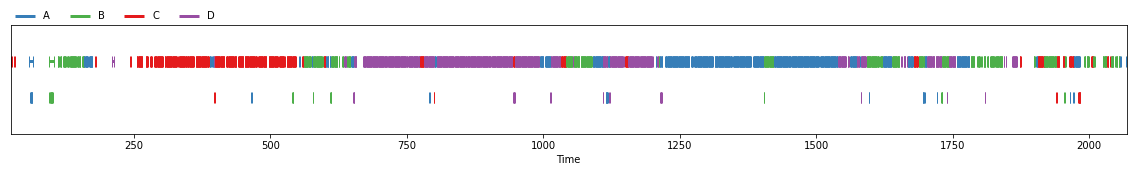

In [ ]:
reference = Annotation()
speaker_dict_true={1:'A', 2:'B', 3:'C', 4:'D'}
for i in range(time_stamp_us.shape[0]):
  reference[Segment(time_stamp_us[i][0], time_stamp_us[i][1])]= speaker_dict_true[y_test_us[i]]
reference

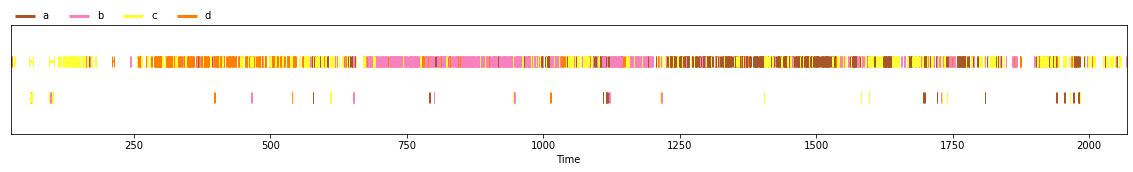

In [ ]:
hypothesis = Annotation()
speaker_dict_hypo={0:'a', 1:'b', 2:'c', 3:'d'}
for i in range(time_stamp_us.shape[0]):
  hypothesis[Segment(time_stamp_us[i][0], time_stamp_us[i][1])]= speaker_dict_hypo[y_test_pred_kmean[i]]
hypothesis

In [ ]:
from pyannote.metrics.diarization import DiarizationErrorRate
diarizationErrorRate = DiarizationErrorRate()
print("DER = {0:.3f}".format(diarizationErrorRate(reference, hypothesis, uem=Segment(0, 2000))))

DER = 0.296


In [ ]:
diarizationErrorRate.optimal_mapping(reference, hypothesis)


{'a': 'A', 'b': 'D', 'c': 'B', 'd': 'C'}

In [ ]:
diarizationErrorRate(reference, hypothesis, detailed=True, uem=Segment(0, 40))


{'confusion': 1.0,
 'correct': 2.806000000000001,
 'diarization error rate': 0.2627430373095112,
 'false alarm': 0.0,
 'missed detection': 0.0,
 'total': 3.806000000000001}

In [ ]:
test_dataset_us = tf.data.Dataset.from_tensor_slices((X_test_us, y_test_us))
test_dataset_us= test_dataset_us.batch(32)
test_dataset_us = test_dataset_us.map(_map_sound)

In [ ]:
X_test_us.shape

(1574, 44, 20)

In [ ]:
print(X.shape)
print(y.shape)

(5913, 44, 20)
(5913,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
def _map_sound(img, label):
    return (img, label)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset= train_dataset.batch(32)
train_dataset = train_dataset.map(_map_sound)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset= test_dataset.batch(32)
test_dataset = test_dataset.map(_map_sound)

In [ ]:
print((train_dataset))

<MapDataset shapes: ((None, 44, 20), (None,)), types: (tf.float32, tf.int64)>


## Model Archtitecture and training

In [ ]:
model = keras.Sequential()

model.add(layers.LSTM(768,  input_shape=(44,20), return_sequences=True))  # returns a sequence of vectors of dimension 768
model.add(layers.LSTM(768,return_sequences=True))  # returns a sequence of vectors of dimension 768
model.add(layers.LSTM(768))  # return a single vector of dimension 768
model.add(layers.Dense(256, activation='tanh')) 
model.add(layers.Dropout(0.01))
model.add(layers.Dense(256, activation=None))
model.add(layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))) # normalization for d vector embedding


The reason we normalize output of last layer is to use the advantage of using normalization is more or less the advantage of cosine similarity over Euclidean distance. 

[Source](https://stats.stackexchange.com/questions/248511/purpose-of-l2-normalization-for-triplet-network#:~:text=Triplet%2Dbased%20distance%20learning%20for%20face%20recognition%20seems%20very%20effective.&text=As%20part%20of%20finding%20an,to%20be%20on%20a%20hypersphere.)


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 44, 768)           2423808   
_________________________________________________________________
lstm_7 (LSTM)                (None, 44, 768)           4721664   
_________________________________________________________________
lstm_8 (LSTM)                (None, 768)               4721664   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               196864    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
lambda_2 (Lambda)            (None, 256)              

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),        # Using Adam Optimizer
    loss=tfa.losses.TripletHardLoss())                 # Use Triplet Hard Loss for making same speaker embeddings similar
# another alternative is to use triplet semi hard loss

In [ ]:
history = model.fit(train_dataset,epochs=70, validation_data=test_dataset)  # Training

Epoch 1/70
148/148 [==============================] - 11s 55ms/step - loss: 1.0263 - val_loss: 1.0088
Epoch 2/70
148/148 [==============================] - 7s 50ms/step - loss: 1.0083 - val_loss: 1.0068
Epoch 3/70
148/148 [==============================] - 7s 50ms/step - loss: 1.0048 - val_loss: 1.0062
Epoch 4/70
148/148 [==============================] - 7s 50ms/step - loss: 1.0030 - val_loss: 1.0053
Epoch 5/70
148/148 [==============================] - 8s 51ms/step - loss: 1.0017 - val_loss: 1.0053
Epoch 6/70
148/148 [==============================] - 8s 52ms/step - loss: 1.0011 - val_loss: 1.0088
Epoch 7/70
148/148 [==============================] - 8s 53ms/step - loss: 1.0058 - val_loss: 1.0076
Epoch 8/70
148/148 [==============================] - 8s 53ms/step - loss: 1.0006 - val_loss: 1.0092
Epoch 9/70
148/148 [==============================] - 8s 52ms/step - loss: 1.0063 - val_loss: 1.0244
Epoch 10/70
148/148 [==============================] - 8s 52ms/step - loss: 1.0007 - val_l

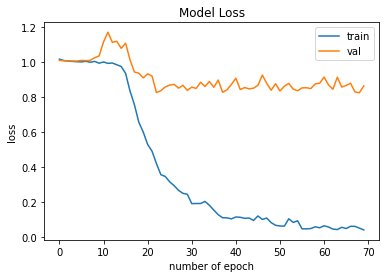

In [ ]:
plt.plot(history.history['loss'])                            # Plotting the train and validation loss accross epochs to analyze performance change
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('number of epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
model.save('lstm_d-vector_model_16_tshl.h5') # saving the model

In [ ]:
test_dataset_us

<MapDataset shapes: ((None, 44, 20), (None,)), types: (tf.float32, tf.int64)>

In [ ]:
test_d_vector_embedding = model.predict(test_dataset_us)
train_d_vector_embedding = model.predict(train_dataset)

print("test_d-vector_embedding: ", test_d_vector_embedding.shape)
print("train_d-vector_embedding ", train_d_vector_embedding.shape )

test_d-vector_embedding:  (1574, 256)
train_d-vector_embedding  (4730, 256)


Converting high-dimensional data**(i.e. 256 dimension)** to low-dimensional data space**(i.e. 2 dimnension)**


In [ ]:
from sklearn.manifold import TSNE
train_2d_embedding = TSNE(n_components=2).fit_transform(train_d_vector_embedding)    # Applying dimentiality reduction to convert embedding into 2D for plotting
test_2d_embedding = TSNE(n_components=2).fit_transform(test_d_vector_embedding)

In [ ]:
print("test_2d_embedding: ", test_2d_embedding.shape)
print("train_2d_embedding ", train_2d_embedding.shape )

test_2d_embedding:  (1574, 2)
train_2d_embedding  (4730, 2)


In [ ]:
a=[]
b=[]
colors = ['black','red','green','blue','yellow','purple', 'orange', 'violet', 'indigo', 'pink', 'beige','brown','grey', 'gold', 'magenta','white', 'red', 'orange']
color_list = []
for i in range(train_2d_embedding.shape[0]):
  a.append(train_2d_embedding[i][0])
  color_list.append(colors[y_train[i]])
for i in range(train_2d_embedding.shape[0]):
  b.append(train_2d_embedding[i][1])

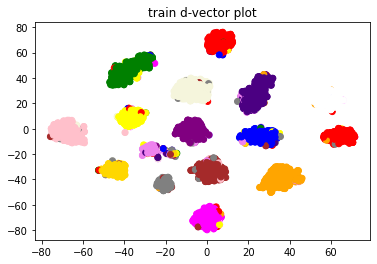

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(a,b,color = color_list)
plt.title('train d-vector plot')          # Plotting the training data's true labels
plt.show()

In [ ]:
a=[]
b=[]
colors = ['black','red','green','blue','yellow','purple', 'orange', 'violet', 'indigo', 'pink', 'beige','brown','grey', 'gold', 'magenta','white', 'red', 'orange']
color_list = []
for i in range(test_2d_embedding.shape[0]):
  a.append(test_2d_embedding[i][0])
  color_list.append(colors[y_test_us[i]])
for i in range(test_2d_embedding.shape[0]):
  b.append(test_2d_embedding[i][1])

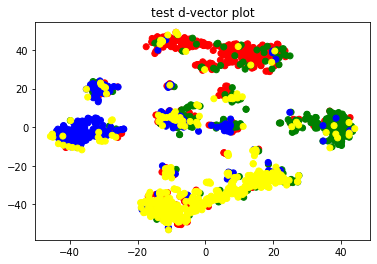

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(a,b,color = color_list)
plt.title('test d-vector plot')                 # Plotting the testing data's true labels
plt.show()

# Clustering Methods
Here we will use the following Traditional Clustering Methods on d vector embeddings for speaker distinction. This shall set the benchmark for GANMM



1.   Kmeans
2.   Spectral Clustering

1.   GMM Clustering







**Kmeans**

In [ ]:
from sklearn.cluster import KMeans

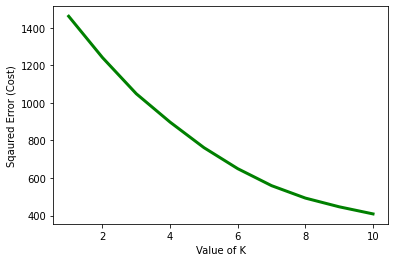

In [ ]:
cost =[]
for i in range(1, 11):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(test_d_vector_embedding)

    # calculates squared error
    # for the clustered points
    cost.append(KM.inertia_)     
  
# plot the cost against K values
plt.plot(range(1, 11), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Sqaured Error (Cost)")
plt.show() # clear the plot

**Elbow method to determine K**

Since the elbow is forming at K=8. So the optimal value will be 8 for performing K-Means.

In [ ]:
KM = KMeans(n_clusters = 4, max_iter = 500)           # Applying K-means on test data
KM.fit(test_d_vector_embedding)
y_test_pred_kmean = KM.labels_

In [ ]:
a=[]
b=[]
colors = ['black','red','green','blue','yellow','purple', 'orange', 'violet', 'indigo']
color_list = []
for i in range(test_2d_embedding.shape[0]):
  a.append(test_2d_embedding[i][0])
  color_list.append(colors[y_test_pred_kmean[i]])
for i in range(test_2d_embedding.shape[0]):
  b.append(test_2d_embedding[i][1])

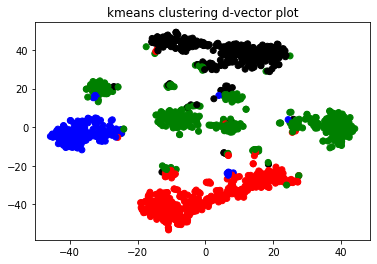

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(a,b,color = color_list)
plt.title('kmeans clustering d-vector plot')      # Plotting the testing data's K-means predicted labels 
plt.show()

**Spectral clustering**

In [ ]:
from spectralcluster import SpectralClusterer

clusterer = SpectralClusterer(              # Applying Specral Clustering on test data
    min_clusters=4,
    max_clusters=20,
    p_percentile=0.90,
    gaussian_blur_sigma=0)

y_test_pred_spectral = clusterer.predict(test_d_vector_embedding)

In [ ]:
a=[]
b=[]
colors = ['black','red','green','blue','yellow','purple', 'orange', 'violet', 'indigo']
color_list = []
for i in range(test_2d_embedding.shape[0]):
  a.append(test_2d_embedding[i][0])
  color_list.append(colors[y_test_pred_spectral[i]])
for i in range(test_2d_embedding.shape[0]):
  b.append(test_2d_embedding[i][1])

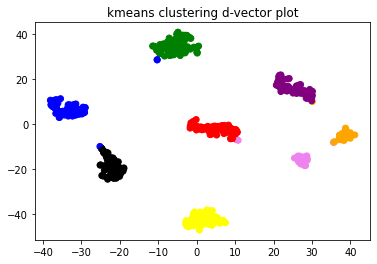

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(a,b,color = color_list)
plt.title('spectral clustering d-vector plot')                   # Plotting the testing data's spectral clustering's predicted labels
plt.show()

**GMM**

An important clustering method to understand generative method based clustering which will be our main goal in future work!! By using GANs

In [ ]:
from sklearn.mixture import GaussianMixture

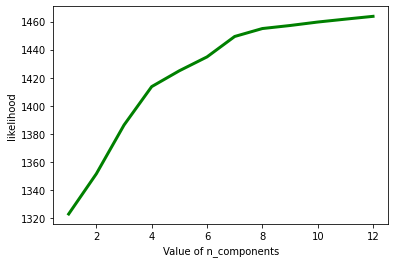

In [ ]:
cost =[]
for i in range(1, 13):
    GMM = GaussianMixture(n_components=i, random_state=0).fit(test_d_vector_embedding)

    # calculates squared error
    # for the clustered points
    cost.append(GMM.lower_bound_)     
  
# plot the cost against K values
plt.plot(range(1, 13), cost, color ='g', linewidth ='3')
plt.xlabel("Value of n_components")
plt.ylabel("likelihood")
plt.show() # clear the plot

See: [link ](https://stats.stackexchange.com/questions/32400/optimal-number-of-components-in-a-gaussian-mixture ), 
for more information about choosing optimal n_components in GMM.

In [ ]:
GMM = GaussianMixture(n_components=8, random_state=0).fit(test_d_vector_embedding)      # Applying GMM on test data
y_test_pred_GMM = GMM.predict(test_d_vector_embedding)

In [ ]:
a=[]
b=[]
colors = ['black','red','green','blue','yellow','purple', 'orange', 'violet', 'indigo']
color_list = []
for i in range(test_2d_embedding.shape[0]):
  a.append(test_2d_embedding[i][0])
  color_list.append(colors[y_test_pred_GMM[i]])
for i in range(test_2d_embedding.shape[0]):
  b.append(test_2d_embedding[i][1])

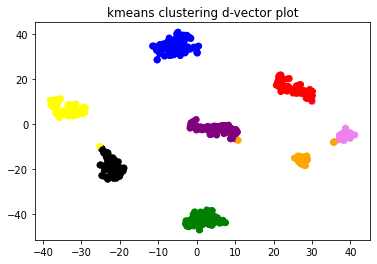

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(a,b,color = color_list)
plt.title('kmeans clustering d-vector plot')                   # Plotting the testing data's GMM's predicted labels
plt.show()